# Models for Mortality Prediction

The parameters used for these models are based on the manual selection of features using observed data, and testing features using chi-squared/fisher exact test's p values < 0.5

We have used two methods to evaluate the data,
1. Averaging scores over 100 random splits of train and test sets in the ratio of 75:25
2. Using

In [1]:
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline 

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
csv = '/home/shikha/Documents/PS1/COVID-19/notebooks/clean_df.csv'
df = pd.read_csv(csv)
df.drop(columns=['Unnamed: 0'], inplace=True)
df

,Sample No.,Patient ID,Study ID,Age,Gender,BMI,Symptoms Presented,Symptoms Present?,Fever,Cough,...,ALKALINE PHOSPHATASE,C-REACTIVE PROTEINS,ECG,CXR,CORADS SCORE ON HRCT,PATIENT CATEGORY,PLASMA THERAPY,Age Above 60?,Temp Groups,CORADS 6
0,1013,IGIB1040201013,IGIB1040201013-1,0.551724,1,0.436782,"fever, cough,breathlessness",1,1,1,...,0.127089,0.152271,sinus rhythm,normal,4.0,5a,No,0,0.2,0.0
1,1014,IGIB1040201014,IGIB1040201014-1,0.241379,0,0.804598,asymptomatic,0,0,0,...,0.172501,0.009346,sinus rhythm,normal,0.0,5b,No,0,0.6,0.0
2,1015,IGIB1040201015,IGIB1040201015-1,0.264368,1,0.402299,asymptomatic,0,0,0,...,0.259224,0.026437,sinus rhythm,normal,0.0,5b,No,0,0.4,0.0
3,1016,IGIB1040201016,IGIB1040201016-1,0.781609,1,0.321839,"fever, cough,breathlessness",1,1,1,...,0.366446,0.443161,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
4,1060,IGIB1040201060,IGIB1040201060-1,0.505747,1,1.000000,"fever,cough",1,1,1,...,0.546200,0.430297,sinus rhythm,normal,5.0,4,No,0,0.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,950,IGIB104020950,IGIB104020950-1,0.551724,1,0.977011,"fever, cough,breathlessness",1,1,1,...,0.219174,0.334734,sinus rhythm,normal,5.0,4,No,0,0.6,0.0
171,965,IGIB104020965,IGIB104020965-1,0.321839,1,0.839080,"fever, cough,breathlessness",1,1,1,...,0.169032,0.362431,sinus tachycardia,normal,5.0,4,No,0,0.6,0.0
172,9667,IGIB1040209667,IGIB1040209667-1,0.747126,1,0.310345,"fever, breathlessness",1,1,0,...,0.177547,0.375164,sinus rhythm,normal,5.0,4,No,1,0.4,0.0
173,9759,IGIB1040209759,IGIB1040209759-1,0.689655,0,0.425287,breathlessness and cough,1,0,1,...,0.669190,0.325282,sinus rhythm,normal,6.0,4,No,1,0.6,1.0


## Model Performance

#### Performance Metrics
The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.

In [3]:
def visualize(x,y, model):
    
        cm = metrics.confusion_matrix(y, model.predict(x))
        plt.figure
        sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
        plt.ylabel('Actual label');
        plt.xlabel('Predicted label');
        plt.savefig('covidseverity.png')
        
        
def ttmodel(X, Y, lm, n):
    
        train_accuracy = [0]*n
        train_precision = [0]*n
        train_recall = [0]*n
        train_f1 = [0]*n

        test_accuracy = [0]*n
        test_precision = [0]*n
        test_recall = [0]*n
        test_f1 = [0]*n
        
        for i in range(n):
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25)

            lm.fit(x_train,y_train)

            train_accuracy[i] = lm.score(x_train,y_train)
            train_precision[i], train_recall[i], train_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_train, lm.predict(x_train), average='binary')

            test_accuracy[i] = lm.score(x_test,y_test)
            test_precision[i], test_recall[i], test_f1[i], s = sklearn.metrics.precision_recall_fscore_support(y_test, lm.predict(x_test), average='binary')

        print("Average training statistics over",n,"runs of this model - ")
        print("Accuracy Score = ", sum(train_accuracy)/n)
        print("Precision Score = ", sum(train_precision)/n)    
        print("Recall Score = ", sum(train_recall)/n)   
        print("F1 Score = ", sum(train_f1)/n) 

        print()
        
        print("Average testing statistics over",n,"runs of this model - ")
        print("Accuracy Score = ", sum(test_accuracy)/n)
        print("Precision Score = ", sum(test_precision)/n)    
        print("Recall Score = ", sum(test_recall)/n)   
        print("F1 Score = ", sum(test_f1)/n) 
        
        visualize(x_test, y_test, lm)
        
        
def cvmodel(X, Y, lm, cv):
    
        from sklearn.model_selection import cross_validate
        scoring = ['f1','roc_auc']
        scores = cross_validate(lm, X, Y, cv=cv, scoring = scoring, return_train_score=True)
        
        for k,v in scores.items():
            ans = [min(v),sum(v)/len(v),max(v)]
            print(k,"=",ans)
            print()


## Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Using averaging over train-test Split

/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shikha/snap/jupyter/common/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average training statistics over 100 runs of the logistic regression model - 
Accuracy Score =  0.9507633587786272
Precision Score =  0.9154214235626769
Recall Score =  0.7003646186544795
F1 Score =  0.789965493876199

Average testing statistics over 100 runs of the logistic regression model - 
Accuracy Score =  0.9127272727272728
Precision Score =  0.7607601010101008
Recall Score =  0.538956349206349
F1 Score =  0.5992476298211588


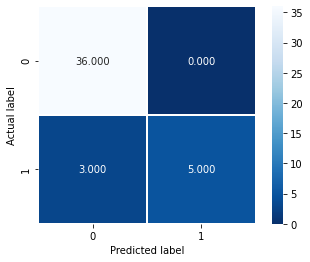

In [5]:
log_reg = LogisticRegression(solver = 'liblinear', max_iter = 1000, penalty = 'l1', C = 3)

#Maybe - Temp, SPO2, TOTAL PROTEINS, SODIUM
X = df[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = df['Outcome']

ttmodel(X, Y, log_reg, 100)

### Using K-Fold Cross Validation

Values for minimum, average and maximum using K-fold cross validation.

In [6]:
cvmodel(X, Y, log_reg, 7)

fit_time = [0.0028276443481445312, 0.00390587534223284, 0.006338596343994141]

score_time = [0.0043163299560546875, 0.00483982903616769, 0.00542449951171875]

test_f1 = [0.5714285714285715, 0.7537414965986393, 0.8571428571428571]

train_f1 = [0.7647058823529412, 0.8231236354190798, 0.9047619047619048]

test_roc_auc = [0.8333333333333333, 0.9434137291280148, 1.0]

train_roc_auc = [0.955703211517165, 0.9633694563096558, 0.9819121447028424]



## Random Forest Classifier

### Using averaging over train-test Split

Average training statistics over 100 runs of the logistic regression model - 
Accuracy Score =  0.9939694656488552
Precision Score =  0.9942726954418132
Recall Score =  0.9606973093555906
F1 Score =  0.9767103377022872

Average testing statistics over 100 runs of the logistic regression model - 
Accuracy Score =  0.9302272727272729
Precision Score =  0.8751547619047614
Recall Score =  0.6102799422799423
F1 Score =  0.6961627930892635


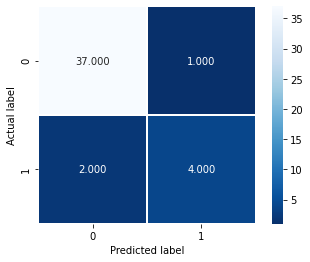

In [7]:
rf = RandomForestClassifier(n_estimators=10)
#Maybe - Temp, SPO2, TOTAL PROTEINS, SODIUM
X = df[['Age Above 60?','Gender','Temp Groups','Respiratory rate(breaths per minute)','Symptoms Present?','Co-morbidity?','Cough','Breathlessness','Hypertension','C-REACTIVE PROTEINS','UREA']]
Y = df['Outcome']

ttmodel(X, Y, rf, 100)

### Using K-Fold Cross Validation

Values for minimum, average and maximum using K-fold cross validation.

In [8]:
cvmodel(X, Y, rf, 7)

fit_time = [0.01225590705871582, 0.014336858476911272, 0.01693439483642578]

score_time = [0.00685572624206543, 0.008382252284458705, 0.01019287109375]

test_f1 = [0.3333333333333333, 0.6875283446712018, 0.888888888888889]

train_f1 = [0.9500000000000001, 0.9749039578307872, 1.0]

test_roc_auc = [0.7727272727272727, 0.9090909090909091, 1.0]

train_roc_auc = [0.9987080103359173, 0.9997890629119865, 1.0]

